## Week 10: Image Analysis

> ### Application: Grain Size Measurement - Challenge Problem Solution

#### Load packages

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from skimage import io, color, measure
import pandas as pd

from PIL import Image
from IPython.display import display

from pathlib import Path

In [6]:
#img = cv.imread("grains callister.png")
#img=img[8:270, 10:230]
img=cv.imread('proeutectoid alpha and pearlite.png')
img=img[0:400, :]
img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
img_shift=cv.pyrMeanShiftFiltering(img, 11, 21)  #acts on original image

gray=cv.cvtColor(img_shift,cv.COLOR_BGR2GRAY) #move img to gray scale
blur=cv.GaussianBlur(gray,(3,3),0) # acts on gray scale image

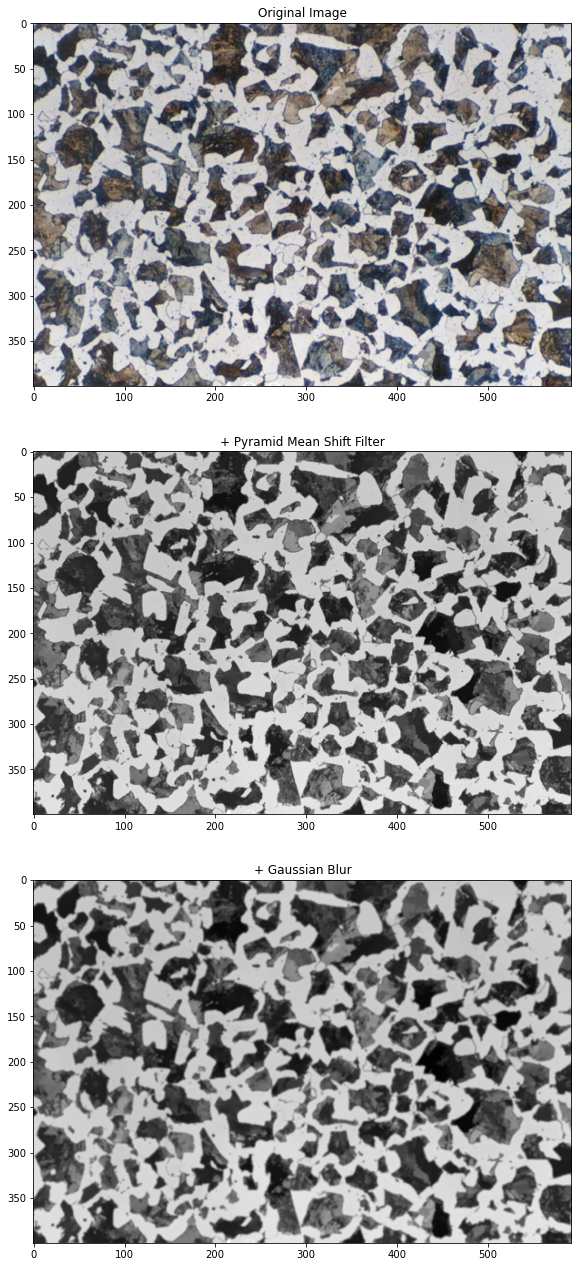

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,figsize=(8, 18))
ax1.imshow(img)
ax2.imshow(gray, cmap='gray')
ax3.imshow(blur, cmap='gray')
ax1.set_title('Original Image')
ax2.set_title('+ Pyramid Mean Shift Filter')
ax3.set_title('+ Gaussian Blur')
plt.tight_layout()

#### Now threshold our image to black (0) & white (255) 

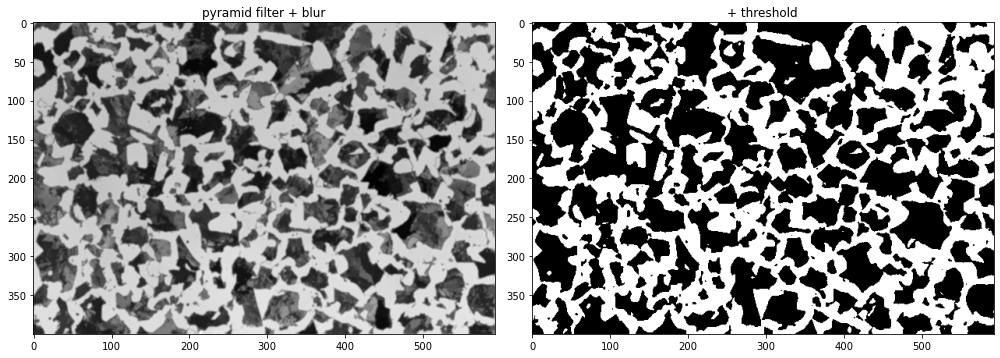

In [13]:
image_to_threshold=blur

#************** 3 choices here for performing threshold *********************
#ret, thresh = cv.threshold(image_to_threshold,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
ret, thresh = cv.threshold(image_to_threshold,165,255,cv.THRESH_BINARY)
#thresh= cv.adaptiveThreshold(image_to_threshold, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV, 27, 0)
#thresh = cv.adaptiveThreshold(image_to_threshold,220,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,5) # notice using gray here not img

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(14, 7))
ax1.imshow(blur, cmap='gray')
ax2.imshow(thresh, cmap='gray')
ax1.set_title('pyramid filter + blur')
ax2.set_title('+ threshold')

plt.tight_layout()

#### Now define a few images we  need to apply our watershed routine. 

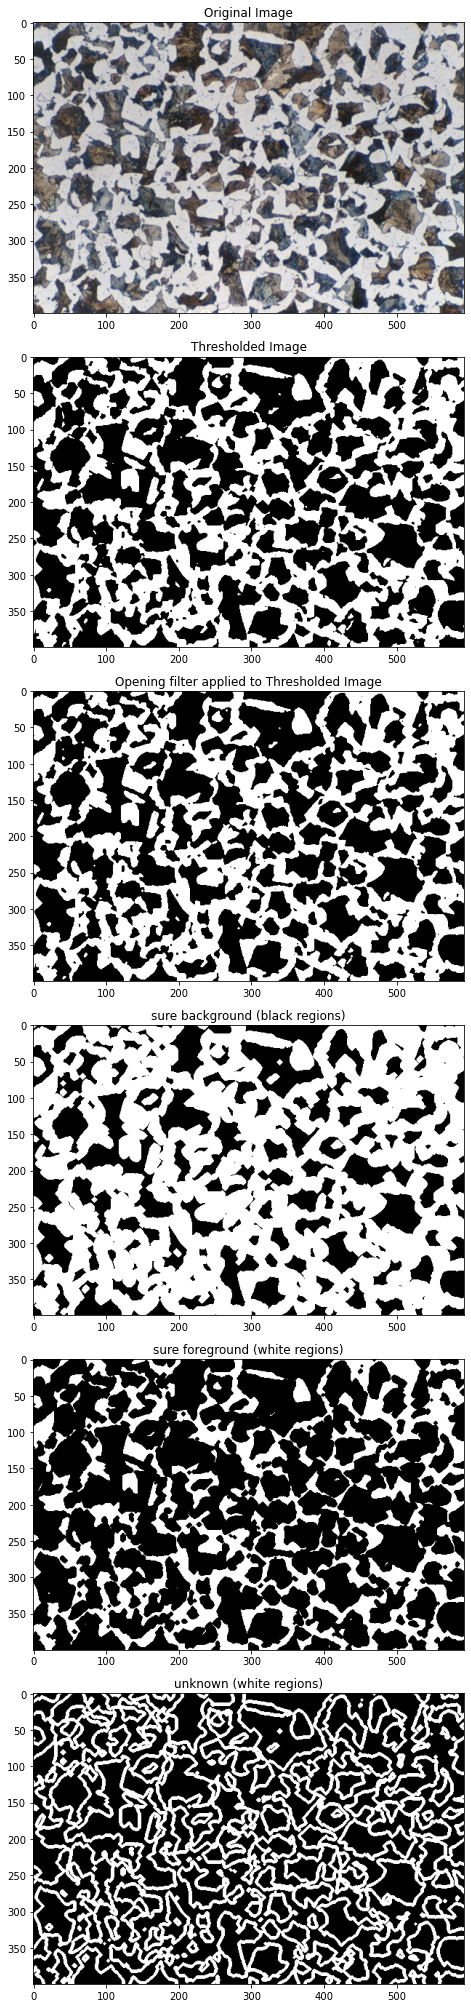

In [20]:
kernel=cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
#kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
# kernel=cv.getStructuringElement(cv.MORPH_RECT,(3,3))

# noise removal
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations=1)

# sure background area
#sure_bg = cv.dilate(opening,kernel,iterations=2)

bgt = cv.dilate(opening,kernel,iterations = 3)
ret,sure_bg = cv.threshold(bgt,1,128,1)

sure_bg=bgt

# Finding sure foreground area
sure_fg = cv.erode(opening,kernel,iterations=2)

# Finding unknown region
unknown = cv.subtract(sure_bg,sure_fg)
#unknown=cv.add(sure_fg,sure_bg)


# ******************* Display results of each step ********************

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, ncols=1,figsize=(8, 28))
ax1.imshow(img, cmap='gray')
ax2.imshow(thresh, cmap='gray')
ax3.imshow(opening, cmap='gray')
ax4.imshow(sure_bg, cmap='gray')
ax5.imshow(sure_fg, cmap='gray')
ax6.imshow(unknown, cmap='gray')

ax1.set_title('Original Image')
ax2.set_title('Thresholded Image')
ax3.set_title('Opening filter applied to Thresholded Image')
ax4.set_title('sure background (black regions)')
ax5.set_title('sure foreground (white regions)')
ax6.set_title('unknown (white regions)')
plt.tight_layout()

In [21]:
unknown

array([[  0, 255, 255, ...,   0,   0,   0],
       [  0, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

#### Label groups of connected pixels with integers (labels)

In [22]:
# Marker labelling
# cv2.connectedComponents(). labels background of the image with 0, 
#then other objects are labelled with integers starting from 1.
ret, markers = cv.connectedComponents(sure_fg)
# bw_unknown=unknown
# bw_unknown[bw_unknown==128]=0
# ret, markers = cv.connectedComponents(bw_unknown)
# marker1=markers

In [23]:
markers

array([[1, 0, 0, ..., 9, 9, 9],
       [1, 0, 0, ..., 9, 9, 9],
       [0, 0, 0, ..., 9, 9, 9],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

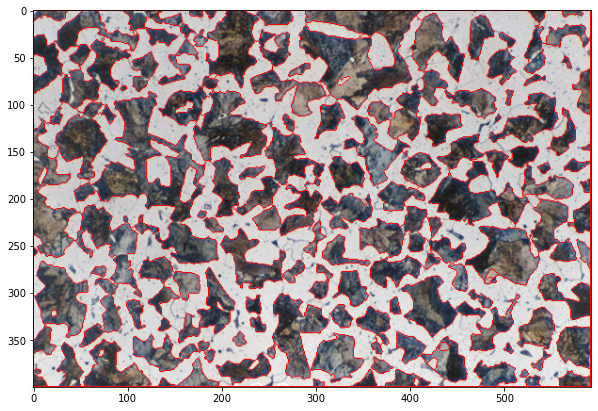

In [24]:
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv.watershed(img,markers)  # img needs shape (pix, pix, 3), markers is (pix, pix)

img[markers ==-1] = [255,0,0]

#display(Image.fromarray(markers))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) # 1x1 grid, first subplot

ax.imshow(img)

plt.show()


#### Change the marker labels to colors and combine with the original image

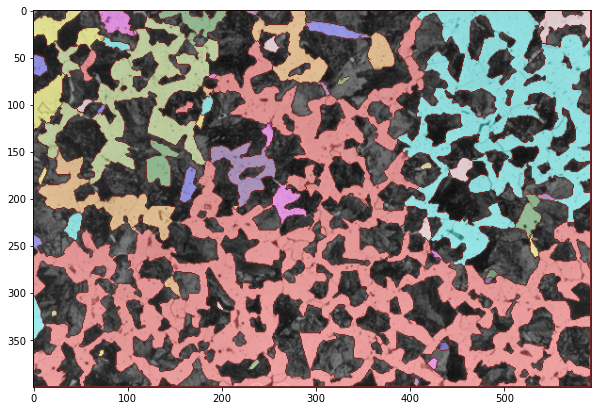

In [57]:
img2=color.label2rgb(markers, image=img, bg_label=1, alpha=0.3)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111) # 1x1 grid, first subplot
ax.imshow(img2);
plt.show()

#### Each colored grain can now be analyzed and placed in a Pandas DataFrame

In [30]:
pixels_to_μm=0.9  # μm per pixel
propList=['label','area','equivalent_diameter','orientation','major_axis_length', 'minor_axis_length','perimeter']
#propList=['equivalent_diameter','orientation','area','major_axis_length']
props=measure.regionprops_table(markers, properties=propList)

grain_data=pd.DataFrame(props)

grain_data.head()

,label,area,equivalent_diameter,orientation,major_axis_length,minor_axis_length,perimeter
0,1,109895,374.062374,1.526330,676.714341,455.715027,20238.014706
1,3,720,30.277590,-1.131851,50.993402,26.897806,156.953319
2,4,641,28.568279,1.103538,37.527713,23.586825,120.497475
3,6,806,32.034842,1.434534,70.212295,24.417219,216.130988
4,7,30,6.180387,1.449547,11.583663,3.774309,21.242641


In [34]:
total_pixels=400*593
total_pixels

237200

In [36]:
grain_data.loc[:,'area'].sum() #interface pixels labeled -1 don't show up in table

218024

In [42]:
len(markers[markers==0]) #we have one lonely pixel still labeled 0

1

In [76]:
background_pix=len(markers[markers==1])
interface_pix=len(markers[markers==-1])
proeutec_pix=len(markers[markers>1])
total_pix=background_pix+interface_pix+proeutec_pix

print(f'total pixels = {total_pix}')
print(f'interface % = {interface_pix/total_pix*100:0.1f}%')
#giving half of the interface pixels to background and half to proeutectoid ferrite: 
print('Give half of the interface pixs to each of the following:')
print(f'background % = {(background_pix+interface_pix/2)/total_pix*100:0.1f}%')
print(f'Proeutectoid % = {(proeutec_pix+interface_pix/2)/total_pix*100:0.1f}%')

total pixels = 237199
interface % = 8.1%
Give half of the interface pixs to each of the following:
background % = 50.4%
Proeutectoid % = 49.6%
